# Model stacking and boosting

In our previous analysis, we have shown that the linear regression and gradient boosting random forest regression serves as the best linear and non-linear models, respectively. Furthermore, their performance varies across different historical periods. Here, we explore two last-mile optimization techniques:

## Model stacking
Model stacking is a technique that combines multiple models to improve predictive performance. Specifically, we consider a linear combination of the predictions from the linear regression and gradient boosting random forest regression models. Instead of further train some meta models, we manually assign the weights to be inversely proportional to the mean square error (MSE) of the two models over the previous 252 days. In other words, we assign a higher weight to the model with better performance over the last 252 days.
$$ \hat{\beta}^{F, stacking}_{i, t} = \frac{1}{(\frac{1}{MSE^{lr}} + \frac{1}{MSE^{GBRF}})}(\frac{1}{MSE^{lr}} \hat{\beta}^{F, lr}_{i, t} +  \frac{1}{MSE^{GBRF}} \hat{\beta}^{F, GBRF}_{i, t}) $$
, where $\hat{\beta}^{F, stacking}_{i, t}$ is the stacked model prediction for stock $i$ at time $t$, $\hat{\beta}^{F, lr}_{i, t}$ is the linear regression prediction, and $\hat{\beta}^{F, GBRF}_{i, t}$ is the gradient boosting random forest regression prediction, $MSE^{lr}$ is the mean square error of the linear regression model calculated from $t-252$ to $t-1$, and $MSE^{GBRF}$ is the mean square error of the gradient boosting random forest regression model.

## Model boosting
Model boosting is a technique that multiple model sequentially take care the residuals of the previous model to achieve better predictive performance. We treat the linear regression model as the base model and the gradient boosting random forest regression model as the boosting model. The idea is to first fit a linear regression model to the data, then fit a gradient boosting random forest regression model to the residuals of the linear regression model. The final prediction is the sum of the predictions from both models,

$$\hat{\beta}^{F, boosting}_{i, t} = \hat{\beta}^{F, lr}_{i, t} + \hat{\varepsilon}^{F, GBRF}_{i, t}$$
where $\hat{\beta}^{F, boosting}_{i, t}$ is the boosting model prediction for stock $i$ at time $t$, $\hat{\beta}^{F, lr}_{i, t}$ is the linear regression prediction, and $\hat{\varepsilon}^{F, GBRF}_{i, t}$ is the predicted residuals by the gradient boosting random forest regression model

Specifically,
- Step 1: Train and fit the linear regression model on the training data;
- Step 2: Calculate the residuals of the linear regression model $\varepsilon_{i, t} = Y_{i, t} - \hat{Y}^{lr}_{i, t}$;
- Step 3: Train and fit the gradient boosting random forest regression model on the residuals;
- Step 4: The final prediction is the sum of the linear regression prediction and the gradient boosting random forest regression prediction:




In [ ]:
import os, sys, copy, scipy, datetime, tqdm, collections, itertools, pickle, json
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import model_lib

if __name__ == "__main__":
    sys.path.append(os.path.join(os.getcwd(), '..'))

import utils

# load data
file_name = os.path.join(os.getcwd(), "..", "data", "data_transformed.npz")
data = np.load(file_name, allow_pickle=True)
code_list = data["code_list"].tolist(); time_axis = data["time_axis"].tolist()
forward_beta = data["forward_beta"]
N = len(code_list); T = len(time_axis)

file_name = os.path.join(os.getcwd(), "..", "data", "feature_dict.pkl")
with open(file_name, "rb") as f:
    feature_dict = pickle.load(f)

# define training and testing period
t_idx = np.searchsorted(time_axis, datetime.datetime(2012, 1, 1))
t_train_start_idx_list = []; t_train_end_idx_list = []; t_test_start_idx_list = []; t_test_end_idx_list = []
while True:
    t_train_start_idx = t_idx - 251
    t_train_end_idx = t_idx
    t_test_start_idx = t_train_end_idx + 1
    t_test_end_idx = min(t_test_start_idx + 124, T - 1)
    t_train_start_idx_list.append(t_train_start_idx)
    t_train_end_idx_list.append(t_train_end_idx)
    t_test_start_idx_list.append(t_test_start_idx)
    t_test_end_idx_list.append(t_test_end_idx)
    if t_test_start_idx >= T:
        break
    t_idx += 125

# construct data
file_name = os.path.join(os.getcwd(), "..", "feature_engineer", "feature_engineer_summary.pkl")
with open(file_name, "rb") as f:
    feature_selection_summary = pickle.load(f)
feature_pool = feature_selection_summary["selected_feature"]
current_feature = feature_pool[0:5]
X = np.zeros((N, T, len(current_feature))); X[:] = np.nan
for i in range(len(current_feature)):
    if current_feature[i] in feature_dict:
        X[:, :, i] = feature_dict[current_feature[i]]
    else:
        raise Exception("Feature {} not found.".format(current_feature[i]))

file_name = os.path.join(os.getcwd(), "results", "model_performance_summary.pkl")
with open(file_name, "rb") as f:
    model_performance_summary = pickle.load(f)

save_filename = os.path.join(os.getcwd(), "results", "model_predicted_value.pkl")
if os.path.exists(save_filename):
    model_predicted_value = pickle.load(open(save_filename, "rb"))
else:
    model_predicted_value = {}
    linear_regression_pred = np.zeros((N, T)); linear_regression_pred[:] = np.nan
    model = model_lib.model_linear_regression(current_feature, "top5_feature")
    model.model_performance(is_stock_dependent=False, auto_select_feature=True)
    for t_idx in tqdm.tqdm(range(T)):
        if t_idx < t_test_start_idx_list[0]:
            continue
        X_test = X[:, t_idx, :]
        Y_test = forward_beta[:, t_idx]
        stock_idx_1 = np.where(~np.any(np.isnan(X_test), axis=1))[0]
        stock_idx_2 = np.where(~np.isnan(Y_test))[0]
        stock_idx = np.intersect1d(stock_idx_1, stock_idx_2)
        X_test = X_test[stock_idx, :]; Y_test = Y_test[stock_idx]
        if X_test.shape[0] == 0:
            continue
        Y_pred = model.predict(X_test, time_axis[t_idx], auto_select_feature=False)
        linear_regression_pred[stock_idx, t_idx] = Y_pred.flatten()

    model_predicted_value["linear_regression"] = linear_regression_pred

    lasso_regression_pred = np.zeros((N, T)); lasso_regression_pred[:] = np.nan
    model = model_lib.model_ridge_lasso_regression(current_feature, "top5_feature", "lasso")
    model.model_performance(is_stock_dependent=False)
    for t_idx in tqdm.tqdm(range(T)):
        if t_idx < t_test_start_idx_list[0]:
            continue
        X_test = X[:, t_idx, :]
        Y_test = forward_beta[:, t_idx]
        stock_idx_1 = np.where(~np.any(np.isnan(X_test), axis=1))[0]
        stock_idx_2 = np.where(~np.isnan(Y_test))[0]
        stock_idx = np.intersect1d(stock_idx_1, stock_idx_2)
        X_test = X_test[stock_idx, :]
        if X_test.shape[0] == 0:
            continue
        Y_pred = model.predict(X_test, time_axis[t_idx])
        lasso_regression_pred[stock_idx, t_idx] = Y_pred.flatten()

    model_predicted_value["lasso_regression"] = lasso_regression_pred

    ridge_regression_pred = np.zeros((N, T)); ridge_regression_pred[:] = np.nan
    model = model_lib.model_ridge_lasso_regression(current_feature, "top5_feature", "ridge")
    model.model_performance(is_stock_dependent=False)
    for t_idx in tqdm.tqdm(range(T)):
        if t_idx < t_test_start_idx_list[0]:
            continue
        X_test = X[:, t_idx, :]
        Y_test = forward_beta[:, t_idx]
        stock_idx_1 = np.where(~np.any(np.isnan(X_test), axis=1))[0]
        stock_idx_2 = np.where(~np.isnan(Y_test))[0]
        stock_idx = np.intersect1d(stock_idx_1, stock_idx_2)
        X_test = X_test[stock_idx, :]
        if X_test.shape[0] == 0:
            continue
        Y_pred = model.predict(X_test, time_axis[t_idx])
        ridge_regression_pred[stock_idx, t_idx] = Y_pred.flatten()

    model_predicted_value["ridge_regression"] = ridge_regression_pred

    principal_component_regression_pred = np.zeros((N, T)); principal_component_regression_pred[:] = np.nan
    model = model_lib.model_principal_component_regression(current_feature, "top5_feature")
    model.model_performance(is_stock_dependent=False)

    for t_idx in tqdm.tqdm(range(T)):
        if t_idx < t_test_start_idx_list[0]:
            continue
        X_test = X[:, t_idx, :]
        Y_test = forward_beta[:, t_idx]
        stock_idx_1 = np.where(~np.any(np.isnan(X_test), axis=1))[0]
        stock_idx_2 = np.where(~np.isnan(Y_test))[0]
        stock_idx = np.intersect1d(stock_idx_1, stock_idx_2)
        X_test = X_test[stock_idx, :]
        if X_test.shape[0] == 0:
            continue
        Y_pred = model.predict(X_test, time_axis[t_idx])
        principal_component_regression_pred[stock_idx, t_idx] = Y_pred.flatten()

    model_predicted_value["principal_component_regression"] = principal_component_regression_pred

    least_angle_regression_pred = np.zeros((N, T)); least_angle_regression_pred[:] = np.nan
    model = model_lib.model_least_angle_regression(current_feature, "top5_feature")
    model.model_performance(is_stock_dependent=False)
    for t_idx in tqdm.tqdm(range(T)):
        if t_idx < t_test_start_idx_list[0]:
            continue
        X_test = X[:, t_idx, :]
        Y_test = forward_beta[:, t_idx]
        stock_idx_1 = np.where(~np.any(np.isnan(X_test), axis=1))[0]
        stock_idx_2 = np.where(~np.isnan(Y_test))[0]
        stock_idx = np.intersect1d(stock_idx_1, stock_idx_2)
        X_test = X_test[stock_idx, :]
        if X_test.shape[0] == 0:
            continue
        Y_pred = model.predict(X_test, time_axis[t_idx])
        least_angle_regression_pred[stock_idx, t_idx] = Y_pred.flatten()

    model_predicted_value["least_angle_regression"] = least_angle_regression_pred

    partial_least_angle_regression_pred = np.zeros((N, T)); partial_least_angle_regression_pred[:] = np.nan
    model = model_lib.model_partial_least_square_regression(current_feature, "top5_feature")
    model.model_performance(is_stock_dependent=False)
    for t_idx in tqdm.tqdm(range(T)):
        if t_idx < t_test_start_idx_list[0]:
            continue
        X_test = X[:, t_idx, :]
        Y_test = forward_beta[:, t_idx]
        stock_idx_1 = np.where(~np.any(np.isnan(X_test), axis=1))[0]
        stock_idx_2 = np.where(~np.isnan(Y_test))[0]
        stock_idx = np.intersect1d(stock_idx_1, stock_idx_2)
        X_test = X_test[stock_idx, :]
        if X_test.shape[0] == 0:
            continue
        Y_pred = model.predict(X_test, time_axis[t_idx])
        partial_least_angle_regression_pred[stock_idx, t_idx] = Y_pred.flatten()

    model_predicted_value["partial_least_angle_regression"] = partial_least_angle_regression_pred

    gb_random_forest_pred = np.zeros((N, T)); gb_random_forest_pred[:] = np.nan
    model = model_lib.model_tree_based_regression(current_feature, "top5_feature", True)
    time_hist, mse_hist = model.model_performance(is_stock_dependent=False)

    for t_idx in tqdm.tqdm(range(T)):
        if t_idx < t_test_start_idx_list[0]:
            continue
        X_test = X[:, t_idx, :]
        Y_test = forward_beta[:, t_idx]
        stock_idx_1 = np.where(~np.any(np.isnan(X_test), axis=1))[0]
        stock_idx_2 = np.where(~np.isnan(Y_test))[0]
        stock_idx = np.intersect1d(stock_idx_1, stock_idx_2)
        X_test = X_test[stock_idx, :]
        if X_test.shape[0] == 0:
            continue
        Y_pred = model.predict(X_test, time_axis[t_idx])
        gb_random_forest_pred[stock_idx, t_idx] = Y_pred.flatten()

    model_predicted_value["gb_random_forest"] = gb_random_forest_pred
    
    neural_networks_pred = np.zeros((N, T)); neural_networks_pred[:] = np.nan
    model = model_lib.model_neural_networks(current_feature, "top5_feature")
    model.model_performance()

    for t_idx in tqdm.tqdm(range(T)):
        if t_idx < t_test_start_idx_list[0]:
            continue
        X_test = X[:, (t_idx-23):(t_idx+1), :]
        Y_test = forward_beta[:, t_idx]
        X_temp = X_test.reshape((X_test.shape[0], -1))
        stock_idx_1 = np.where(~np.any(np.isnan(X_temp), axis=1))[0]
        stock_idx_2 = np.where(~np.isnan(Y_test))[0]
        stock_idx = np.intersect1d(stock_idx_1, stock_idx_2)
        X_test = X_test[stock_idx, :, :]
        if X_test.shape[0] == 0:
            continue
        Y_pred = model.predict(X_test, time_axis[t_idx])
        neural_networks_pred[stock_idx, t_idx] = Y_pred.flatten()

    model_predicted_value["neural_networks"] = neural_networks_pred
    with open(save_filename, "wb") as f:
        pickle.dump(model_predicted_value, f)

#%% model stacking with weightes by linear regression + gb random forest
key_list = list(model_predicted_value.keys())
X = np.zeros((N, T, len(key_list))); X[:] = np.nan
for i in range(len(key_list)):
    if key_list[i] in model_predicted_value:
        X[:, :, i] = model_predicted_value[key_list[i]]
    else:
        raise Exception("Model {} not found.".format(key_list[i]))

t_idx = np.searchsorted(time_axis, datetime.datetime(2012, 1, 1))
t_update_freq = 125
model_stack_pred = np.zeros((N, T)); model_stack_pred[:] = np.nan
time_hist = []; mse_hist = []; mse_cache = []

for t_idx in tqdm.tqdm(np.arange(t_idx, T, 1)):
    t_train_start_idx = t_idx - 251
    t_train_end_idx = t_idx
    t_test_start_idx = t_train_end_idx + 1
    t_test_end_idx = min(t_test_start_idx + t_update_freq - 1, T - 1)
    if t_train_end_idx >= T:
        break

    Y = forward_beta[:, t_train_start_idx:t_train_end_idx + 1]
    Y_linreg = model_predicted_value["linear_regression"][:, t_train_start_idx:t_train_end_idx + 1]
    Y_rf = model_predicted_value["gb_random_forest"][:, t_train_start_idx:t_train_end_idx + 1]
    linreg_mse = np.nanmean((Y - Y_linreg) ** 2)
    rf_mse = np.nanmean((Y - Y_rf) ** 2)
    weight = np.array([1 / linreg_mse, 1 / rf_mse])
    weight = weight / np.sum(weight)
    Y_pred = weight[0]*model_predicted_value["linear_regression"][:, t_idx] + weight[1]*model_predicted_value["gb_random_forest"][:, t_idx]
    model_stack_pred[:, t_idx] = Y_pred.flatten()

model_performance_summary["linreg_gbrf_stacking"] = np.nanmean((forward_beta - model_stack_pred) ** 2)

residual = forward_beta - model_predicted_value["linear_regression"]
boosting_pred = np.zeros((N, T)); boosting_pred[:] = np.nan
t_update_freq = 125

time_hist = []; mse_hist = []
t_idx = np.searchsorted(time_axis, datetime.datetime(2012, 1, 1))
while True:
    t_train_start_idx = t_idx - 251
    t_train_end_idx = t_idx
    t_test_start_idx = t_train_end_idx + 1
    t_test_end_idx = min(t_test_start_idx + t_update_freq - 1, T - 1)
    if t_train_end_idx >= T:
        break

    print("training period: {} - {}; testing period: {} - {}".format(time_axis[t_train_start_idx], time_axis[t_train_end_idx], time_axis[t_test_start_idx], time_axis[t_test_end_idx]))
    X_train = X[:, t_train_start_idx:t_train_end_idx + 1, :]
    Y_train = residual[:, t_train_start_idx:t_train_end_idx + 1]
    data_train = np.concatenate((X_train, Y_train[:, :, np.newaxis]), axis=2)
    data_train = data_train.swapaxes(0, 1).reshape((-1, len(current_feature) + 1))
    data_train = data_train[~np.isnan(data_train).any(axis=1), :]
    data_train = data_train[~np.isinf(data_train).any(axis=1), :]
    X_train = data_train[:, 0:len(current_feature)]; Y_train = data_train[:, [len(current_feature)]]

    X_test = X[:, t_test_start_idx:t_test_end_idx + 1, :]
    Y_test = residual[:, t_test_start_idx:t_test_end_idx + 1]
    data_test = np.concatenate((X_test, Y_test[:, :, np.newaxis]), axis=2)
    data_test = data_test.swapaxes(0, 1).reshape((-1, len(current_feature) + 1))
    data_test = data_test[~np.isnan(data_test).any(axis=1), :]
    data_test = data_test[~np.isinf(data_test).any(axis=1), :]
    X_test = data_test[:, 0:len(current_feature)]; Y_test = data_test[:, [len(current_feature)]]
    if X_test.shape[0] == 0 or X_train.shape[0] <= 100:
        t_idx += 125
        continue

    model = utils.random_forest_regression(X_train, Y_train, X_columns=current_feature, is_gradient_boost=True)
    params_dict = {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.05}
    model.fit(params_dict)
    Y_pred = model.predict(X_test).reshape(-1, 1)
    time_hist.append(time_axis[t_test_start_idx])
    mse_hist.append(np.nanmean((Y_test - Y_pred) ** 2))
    t_idx += t_update_freq

model_performance_summary["linreg_gbrf_boosting"] = np.nanmean(mse_hist)


  0%|          | 0/1006 [00:00<?, ?it/s]C:\Users\infiyfl\AppData\Local\Temp\ipykernel_1092504\1706681671.py:248: RuntimeWarning: Mean of empty slice
  linreg_mse = np.nanmean((Y - Y_linreg) ** 2)
C:\Users\infiyfl\AppData\Local\Temp\ipykernel_1092504\1706681671.py:249: RuntimeWarning: Mean of empty slice
  rf_mse = np.nanmean((Y - Y_rf) ** 2)
100%|██████████| 1006/1006 [00:00<00:00, 5497.29it/s]


training period: 2011-01-04 00:00:00 - 2012-01-03 00:00:00; testing period: 2012-01-04 00:00:00 - 2012-07-02 00:00:00
training period: 2011-07-05 00:00:00 - 2012-07-02 00:00:00; testing period: 2012-07-03 00:00:00 - 2013-01-02 00:00:00
training period: 2011-12-30 00:00:00 - 2013-01-02 00:00:00; testing period: 2013-01-03 00:00:00 - 2013-07-02 00:00:00
training period: 2012-06-29 00:00:00 - 2013-07-02 00:00:00; testing period: 2013-07-03 00:00:00 - 2013-12-30 00:00:00
training period: 2012-12-31 00:00:00 - 2013-12-30 00:00:00; testing period: 2013-12-31 00:00:00 - 2014-06-30 00:00:00
training period: 2013-07-01 00:00:00 - 2014-06-30 00:00:00; testing period: 2014-07-01 00:00:00 - 2014-12-26 00:00:00
training period: 2013-12-27 00:00:00 - 2014-12-26 00:00:00; testing period: 2014-12-29 00:00:00 - 2015-06-26 00:00:00
training period: 2014-06-27 00:00:00 - 2015-06-26 00:00:00; testing period: 2015-06-29 00:00:00 - 2015-12-23 00:00:00
training period: 2014-12-24 00:00:00 - 2015-12-23 00:00:

model: linreg_gbrf_boosting, MSE: 0.1796, improvement: -36.4029%
model: neural_networks, MSE: 0.1520, improvement: -15.4169%
model: baseline, MSE: 0.1317, improvement: 0.0000%
model: ridge_regression, MSE: 0.1315, improvement: 0.1150%
model: least_angle_regression, MSE: 0.1299, improvement: 1.3354%
model: lasso_regression, MSE: 0.1294, improvement: 1.7042%
model: principal_component_regression, MSE: 0.1277, improvement: 2.9965%
model: partial_least_square_regression, MSE: 0.1277, improvement: 3.0236%
model: linear_regression, MSE: 0.1275, improvement: 3.1671%
model: random_forest_regression, MSE: 0.1271, improvement: 3.4442%
model: gb_random_forest_regression, MSE: 0.1228, improvement: 6.7589%
model: linreg_gbrf_stacking, MSE: 0.1221, improvement: 7.2558%


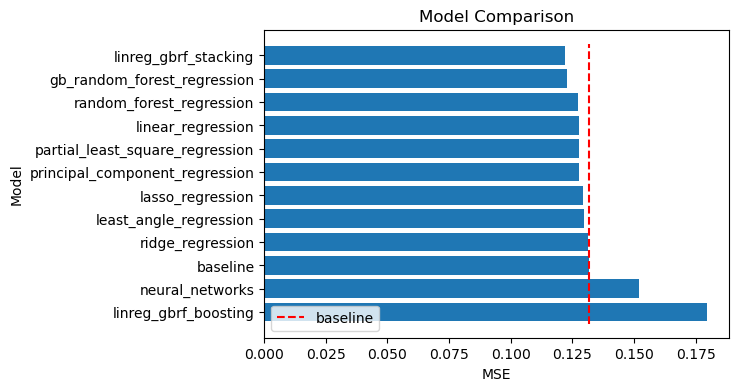

<Figure size 800x400 with 0 Axes>

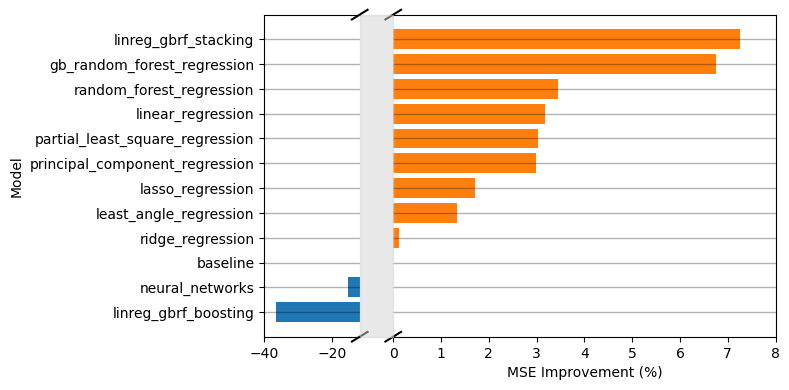

In [5]:
item = list(model_performance_summary.items())
item.sort(key=lambda x: x[1], reverse=True)

file_name = os.path.join(os.getcwd(), "results", "model_performance_summary.pkl")
with open(file_name, "wb") as f:
    pickle.dump(model_performance_summary, f)

# %%
item.sort(key=lambda x: x[1], reverse=True)
plt.figure(figsize=(6, 4))
plt.barh([x[0] for x in item], [x[1] for x in item])
plt.vlines(x=model_performance_summary["baseline"], ymin=-0.5, ymax=len(item)-0.5, color="red", linestyles='--', label="baseline")
plt.xlabel("MSE"); plt.ylabel("Model")
plt.legend(loc="lower left")
plt.title("Model Comparison")

baseline = model_performance_summary["baseline"]
labels = [x[0] for x in item]
values = [100*(baseline-x[1])/baseline for x in item]

for i, v in item:
    print("model: {}, MSE: {:.4f}, improvement: {:.4f}%".format(i, v, 100*(baseline-v)/baseline))

fig = plt.figure(figsize=(8, 4))
fig, (axl, axr) = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 4]})

axl.barh(labels, values, color='C0')
axl.set_xlim(-40, -12)
axl.spines["right"].set_visible(False)
axl.set_ylabel("Model")

for i in range(len(labels)):
    axl.axhline(y=i, color='k', linewidth=1, alpha=0.3)
    axr.axhline(y=i, color='k', linewidth=1, alpha=0.3)

axr.barh(labels, values, color='C1')
axr.set_yticks([])
axr.set_yticklabels([])
axr.set_xlim(0, 8)
axr.spines["left"].set_visible(False)
axr.set_xlabel("MSE Improvement (%)")

d = 0.015
bboxl = axl.get_position()
bboxr = axr.get_position()
ratioL = bboxl.width / bboxl.height
ratioR = bboxr.width / bboxr.height

axl.plot((1 - d/ratioL, 1 + d/ratioL), (-d, +d), transform=axl.transAxes, color='k', clip_on=False)
axl.plot((1 - d/ratioL, 1 + d/ratioL), (1 - d, 1 + d), transform=axl.transAxes, color='k', clip_on=False)

axr.plot((-d/ratioR, +d/ratioR), (-d, +d), transform=axr.transAxes, color='k', clip_on=False)
axr.plot((-d/ratioR, +d/ratioR), (1 - d, 1 + d), transform=axr.transAxes, color='k', clip_on=False)

plt.tight_layout()

from matplotlib.patches import Rectangle

bboxL = axl.get_position()
bboxR = axr.get_position()
x_left = bboxL.x1
x_right = bboxR.x0
y_bottom = bboxL.y0
y_top = bboxL.y1

# Add rectangle to the figure
fig.patches.append(Rectangle(
    (x_left, y_bottom),               # (x, y) bottom-left in figure coords
    x_right - x_left,                 # width
    y_top - y_bottom,                 # height
    transform=fig.transFigure,
    color='lightgray',
    zorder=2,
    clip_on=False,
    alpha=0.5
))

plt.savefig(os.path.join(os.getcwd(), "results", "model_comparison.png"), dpi=300, bbox_inches='tight')


## Conclusion
The model staking improves the model further, reaching a 7.256% performance improvement compared to 3.444% by linear regression and 6.759% by gradient boosting random forest regression. 

Finally, we identify 
- the best model for predicting forward beta: stacking model of linear regression and gradient boosting random forest regression;
- the best feature set for predicting forward beta: 
$$\beta^{F}_{i, t} \sim \beta_{i, t} + \beta_{i, t}^2 + r^{kurt, 60d}_{i,t} + r^{kurt, 60d}_{i,t}*\beta + V_{i, t}$$
, where $\beta^F_{i, t}$ is the forward beta at time $t$ for stock $i$, $\beta_{i, t}$ is the beta at time $t$ for stock $i$, $r^{kurt, 60d}_{i,t}$ is the 60-day kurtosis of stock return at time $t$ for stock $i$, and $V_{i, t}$ is the trading volume at time $t$ for stock $i$.